############################################################################################################
  # Gross (GPP) and Net Primary Production (NPP) model exercise 
############################################################################################################



# 1. Introduction

Gross Primary Production denotes the total amount of carbon fixed in the process of photosynthesis by plants in an ecosystem. A large fraction (up to half of it) is immediately lost again through the process of autotrophic respiration required to provide the necessary energy for maintenance and growth of biomass. The remainder is called Net Primary Production (NPP) which is directly linked to biomass growth and forms the basis for the production of food, fiber, wood, grain fed to livestock, and bio-fuel.
 
There are different strategies to infer GPP from satellite data. In this Notebook we focus on the most widely used approach that builds upon the Light Use Efficiency (LUE) principle. The LUE approach is based on a clear principle, employ simple calculations and have a high simulation precision. Conceptually, the GPP calculation can be expressed as one formula of three elements:
                         
                         GPP = PAR * fAPAR * LUE

Where PAR is the amount of Photosynthetic Activate Radiation retrieved from meteorological data, fAPAR is the Fraction of Absorbed Photosynthetic Activate Radiation infered from optical satellite imagery and LUE is the Light Use Efficiency that represents all of the modelled photosynthetic processess. Meteorological variables such as air temperature, vapour pressure deficit and soil moisture are typical inputs to model the LUE term. LUE models can differ strongly in the way LUE is infered, hence the model driving forcing data can also differ from one model to the other. GPP can be calculated for each timestep that meteorological and fapar is available.

While for GPP a wide variety of models is available, the underlying processes to convert GPP into NPP or biomass production are much less understood. 
Typically the conversion is done at seasonal aggregated values of GPP, making use of a Carbon Use Efficiency (CUE) factor. In this approach the seasonal NPP can be conceptually formulated as: NPP(seasonal) = Sum of GPP from start to end of season * CUE. 
The CUE value can be either modelled, emperically determined or constant fractions can be used. 

In this exercise we aim at providing insights in the basic elements and concepts required for LUE based GPP modelling. Making use of actual GPP model code from the operational Copernicus DMP product, a satellite based GPP calculation will be illustrated on time series of data for a specific site. The resulting GPP time series will be further converted in seasonal NPP values, where the CUE conversion is limited to using a constant fraction. 

To execute a cell, simply move the cursor into the cell and then hit on the "ctrl" + "enter" keys simultaneously.

# 2. Loading Libraries

This section is to load necessary python libraries for data processing and analysis.

In case you don't have the libraries installed. You can simply install them with your python package manager, like pip. Or you can use conda inside a conda environment.

The basic syntax to install a package is

$ pip install packagename

$ conda install packagename

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy 
pd.options.mode.chained_assignment = None  # default='warn'


# 3. Explore inputs

## 3.1 Read example input data
The next cell wil read example data for a single pixel from a CSV file and store the data into a Pandas Dataframe. 
The site represents a woody savanna pixel in Niger.

In [2]:
pixname = r'pix1_belgium_forest'
pixname = r'pix2_niger_savanna'


csv_in  = os.path.join('.\data',pixname+'.csv')
df_inputs = pd.read_csv(csv_in,parse_dates=True,index_col=0,)

## 3.2 Visualize inputs

First we will explore the site by using extracted meteorological and satellite data.
Following variables are extracted for the site:
    - Rainfall [mm]: daily rainfall
    - Air Temperature [°C]: Daily minimum, average and maximum
    - Incoming Solar Radiation [kj/m2/day]: Shortwave incoming solar radiation
    - FAPAR [-]: Fraction of Absorbed Photosynthetic Active Radiation 

All data are normalized to a 10-daily timestep.
The meterological variables are extracted from the ECMWF HRES model at 0.25°. 
The fAPAR is the operational Copernicus 300m fAPAR derived from Proba-V and Sentinel 3 (>2020). 
(https://land.copernicus.eu/global/products/fapar).   

Execute following cell and try to interpret the interaction between the different meteorological variables and the fAPAR signal. 

Text(0.5, 1.0, 'pix2_niger_savanna - Meteorological data & Vegetation Index ')

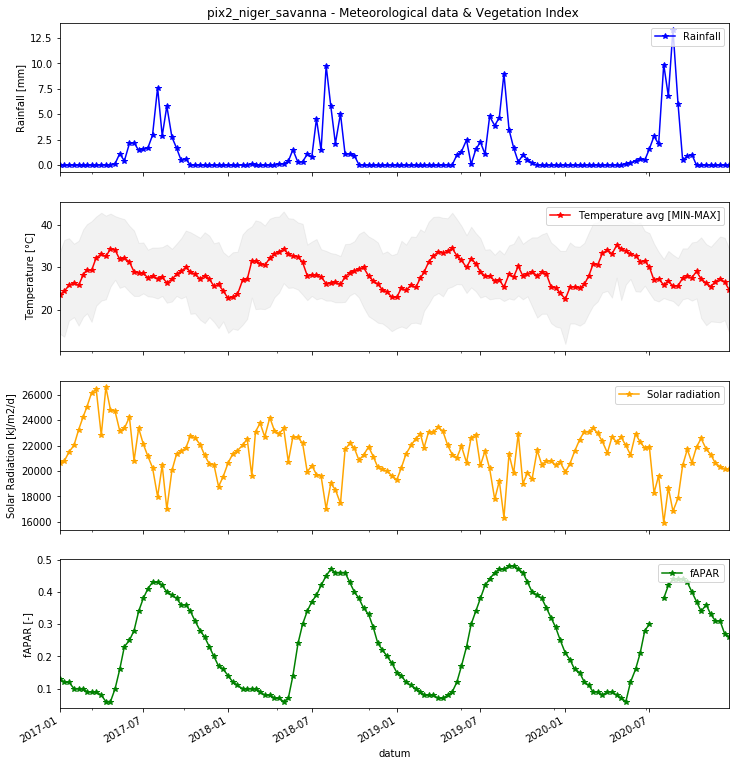

In [3]:
start_date = '2017-01-01' #MIN: 2016-01-01
end_date   = '2020-12-31' #MAX: 2020-12-31

df_inputs_selection = df_inputs[start_date:end_date]

figs, axs = plt.subplots(4, 1, figsize=(12, 14),sharex=True)

df_inputs_selection['prec'].plot(ax=axs[0], label='Rainfall', color='blue',marker='*')

df_inputs_selection['tavg'].plot(ax=axs[1], label='Temperature avg [MIN-MAX]', color='red',marker='*')
axs[1].fill_between(df_inputs_selection.index, df_inputs_selection['tmin'], df_inputs_selection['tmax'],
        color=mpl.colors.to_rgba('gray', 0.1))


df_inputs_selection['rad'].plot(ax=axs[2], label='Solar radiation', color='orange',marker='*')

df_inputs_selection['fapar'].plot(ax=axs[3], label='fAPAR', color='green',marker='*')

axs[0].set_ylabel('Rainfall [mm]')
axs[1].set_ylabel('Temperature [°C]')
axs[2].set_ylabel('Solar Radiation [kJ/m2/d]')
axs[3].set_ylabel('fAPAR [-]')

axs[0].legend(loc='upper right', ncol=5)
axs[1].legend(loc='upper right', ncol=5)
axs[2].legend(loc='upper right', ncol=5)
axs[3].legend(loc='upper right', ncol=5)

axs[0].set_title(pixname+' - Meteorological data & Vegetation Index ')

# 4. Explore and execute GPP model
## 4.1 Explore model structure


In following chapter we will explore an example algorithm of a Light Use Efficiency (LUE) model.

This model is similar to the underlying algorithm of the Copernicus DMP (https://land.copernicus.eu/global/products/dmp) model or WAPOR GPP/NPP model (https://www.fao.org/3/ca9894en/CA9894EN.pdf). It has been simplified however for educational purpose. The version we use in this exercise only includes the effect of temperature on GPP. A more precise model would include a CO2 fertilization factor, a C4 temperature component and a water stress component.

Conceptually, the model used in this Notebook can be formulated as: 

GPP = PAR * fAPAR * LUE. 

    * LUE is defined by : 
    -Maximum Light Use Efficiency (f_LUEmax): A constant fraction that defines the theoretical maximum of LUE in perfect   growing conditions. There are different strategies to obtain these maximum values. In the Copernicus DMP model, the LUE values are estimated by a callibration with in-situ GPP for different biomes. Below we list a number of LUEmax values as defined in this callibration.
        
        Cropland: 1.12
        Cropland irrigated: 1.21
        Grassland: 1.08
        Shrubland: 0.95
        Broadleaved deciduous: 0.99
        Broadleaved evergree: 1.12
        Needleleaved: 0.99
        Mosaic-TreeShrub: 0.80
        
        
    - Temperature Efficiency term (NtempDF): A model subcomponent that represents the effect of temperature on the photosynthetic processess. 
   
   
    * PAR is obtained by multiplying the value of incoming solar radiation with the climatic efficiency. 
    * fAPAR is the fraction of Absorbed Photosynthetic Activate Radiation [0-1]

GPP can be calculated with one function (CalcGPP) that requires following inputs: 
- arr_fapar : Array    : Numpy array containing fAPAR values [-]
- arr_tavg  : Array    : Numpy array containing daily mean air temperature [°C]
- arr_rad   : Array    : Numpy array containing incoming solar radiation values [kj/m2]
- f_LUEmax  : Constant : Light Use Efficiency constant expressed in gC/MJ 

The function returns a dictionary of three arrays (dict_out = {'GPP':arr_GPP,'LUE':arr_LUE,'PAR':arr_par}).
- arr_GPP : Array    : Numpy array containing the model output GPP values [gC/m2/day]
- arr_LUE : Array    : Numpy array containing the intermediate LUE values [gC/MJ]
- arr_PAR : Array    : Numpy array containing the intermediate PAR values [kJ/m2]

The next cell contains both the model code as one example on single values of fapar, temperature and incoming radiation. 

In [4]:
def NtempDF(Td):
    # CONSTANTS
    c1 = 21.77
    HaP = 52750
    Rg = 8.3144
    DeltaS = 704.98
    HdP = 211000

    # CALCULATION
    pTd_numerator = numpy.exp(c1 - (HaP / (Rg * Td)))
    pTd_denominator = 1 + numpy.exp(((DeltaS * Td) - HdP) / (Rg * Td))
    pTd = pTd_numerator / pTd_denominator

    # RESULTS
    return pTd



def calcGPP(arr_fapar,arr_tavg,arr_rad,f_LUEmax=1.08):
    '''
    General note    : all arrays should represent the same spatial grid
    arr_tavg        : Array containing the daily mean temperature values for each grid cell [°C]
    arr_rad         : Array containing shortwave incoming solar radiation for each grid cell [kj/m2]
    LUE             : Light Use Efficiency (expressed as gC/MJ PAR]. Original C-fix value.
    '''


    #Rescaling arrays:
    arr_tavg_k = arr_tavg + 273.13  # Tavg in Kelvin
    arr_rad_u = arr_rad / 1000  # to convert from kj/m2 to MJ/ha
    
   
    ClimaticEff = 0.48 #About 48% of the solar incoming radiation can be potentially used for photosynthesis
    arr_par   = arr_rad_u * ClimaticEff #To convert solar radiation into PAR
    
    
        # CALCULATION
    arr_pTdval = NtempDF(arr_tavg_k)
    arr_LUE =  f_LUEmax  * arr_pTdval
    arr_GPPpot = arr_LUE * arr_par
    arr_GPP = arr_GPPpot * arr_fapar

    dict_out = {'GPP':arr_GPP,'LUE':arr_LUE,'PAR':arr_par}
    
    return dict_out

def main():
    import numpy as np
    arr_tavg, = np.array([20])
    arr_fapar = np.array([0.8])
    arr_rad = np.array([20000])
    GPP = calcGPP(arr_fapar,arr_tavg,arr_rad,f_LUEmax=1.143)
    print(GPP)

if __name__ == "__main__":
    main()

{'GPP': array([8.52836637]), 'LUE': 1.110464371091496, 'PAR': array([9.6])}


## 4.2 Explore GPP model subcomponents


In the next cell we will explore how temperate influences GPP in a small simulation excercise.
We will simulate how the Temperature Efficiency term changes in a temperature range from 0-40°C.

Please note that this temperature function was originally developed for C3 vegetation. C4 vegetation can cope better with higher temperatures, hence the relation would be different. In this model exercise we only output GPP for C3 vegetation.

Text(0.5, 0, 'Temperature [°C]')

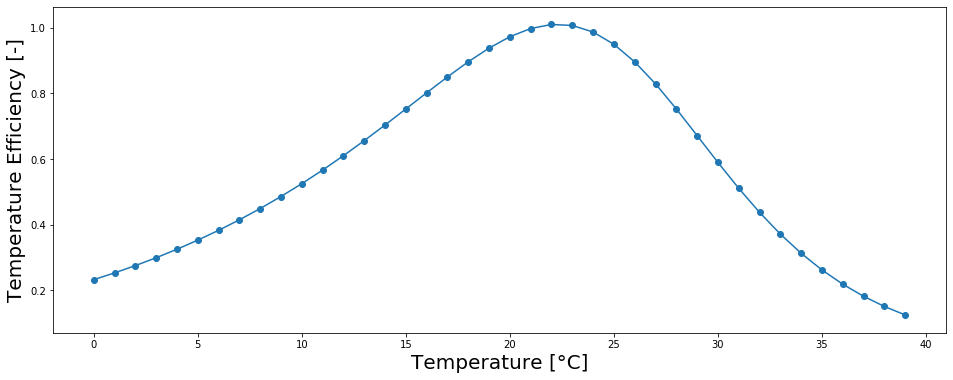

In [11]:
figs, ax = plt.subplots(1, 1, figsize=(16, 6),sharex=True)

temp_celcius = numpy.arange(0,40)
temp_kelvin = temp_celcius + 273.15
temp_efficiency = NtempDF(temp_kelvin)
ax.scatter(temp_celcius,temp_efficiency)

temp_celcius = numpy.arange(0,40)
temp_kelvin = temp_celcius + 273.15
temp_efficiency = NtempDF(temp_kelvin)
ax.plot(temp_celcius,temp_efficiency)
ax.set_ylabel('Temperature Efficiency [-]',size=20)
ax.set_xlabel('Temperature [°C]',size=20)


## 4.3 Run GPP model

Now the inputs and the model algorithm are explored, we will perform a model run for a time series of data.
The code starts from the Pandas dataframe defined before. 
This database holds a 5 year time series of meteorological data (Temperature, Incoming Solar Radiation) and fAPAR. 

The calcGPP model function returns GPP and intermediate LUE and PAR model results.
These time series are plotted together with the fAPAR data to illustrate how the different model run products are interlinked. 

Execute following cell and interpet the time profiles shown. 

Text(0.5, 1.0, 'pix2_niger_savanna - FAPAR & GPP ')

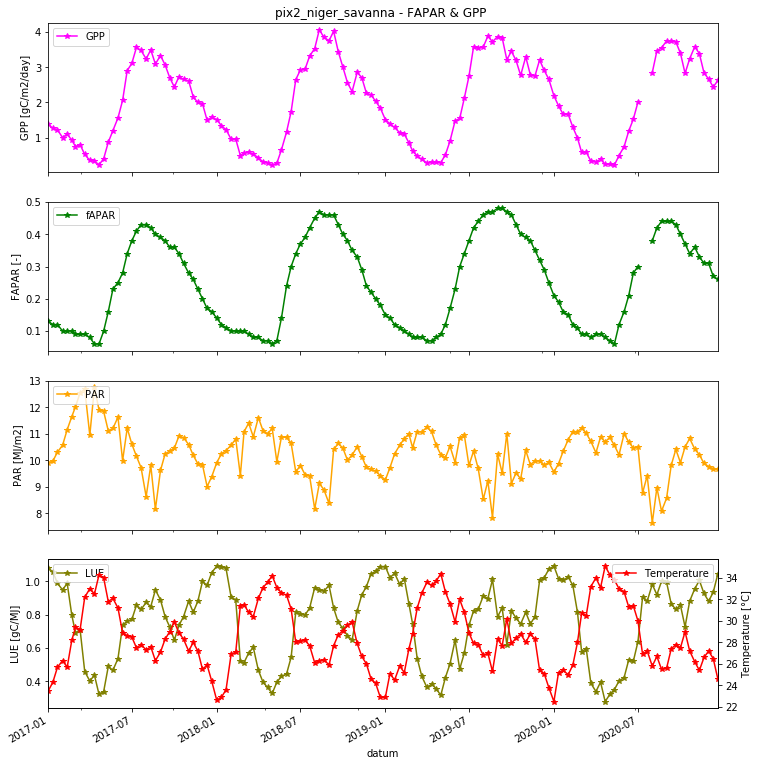

In [12]:
f_LUEmax = 1.08 # LUE value can change according to land cover, see above. 


arr_tavg = df_inputs_selection['tavg'].to_numpy()
arr_fapar = df_inputs_selection['fapar'].to_numpy()
arr_rad = df_inputs_selection['rad'].to_numpy()

dict_out  = calcGPP(arr_fapar,arr_tavg,arr_rad,f_LUEmax) 

df_inputs_selection['GPP'] = dict_out['GPP']
df_inputs_selection['LUE'] = dict_out['LUE']
df_inputs_selection['PAR'] = dict_out['PAR']


figs, axs = plt.subplots(4, 1, figsize=(12, 14),sharex=True)

df_inputs_selection['GPP'].plot(ax=axs[0], label='GPP', color='fuchsia',marker='*')
df_inputs_selection['fapar'].plot(ax=axs[1], label='fAPAR', color='green',marker='*')
df_inputs_selection['PAR'].plot(ax=axs[2], label='PAR', color='orange',marker='*')
df_inputs_selection['LUE'].plot(ax=axs[3], label='LUE', color='olive',marker='*')
ax2 = axs[3].twinx()
df_inputs_selection['tavg'].plot(ax=ax2, label='Temperature', color='red',marker='*')

axs[0].set_ylabel('GPP [gC/m2/day]')
axs[1].set_ylabel('FAPAR [-]')
axs[2].set_ylabel('PAR [MJ/m2]')
axs[3].set_ylabel('LUE [gC/MJ]')
ax2.set_ylabel('Temperature [°C]')

axs[0].legend(loc='upper left', ncol=5)
axs[1].legend(loc='upper left', ncol=5)
axs[2].legend(loc='upper left', ncol=5)
axs[3].legend(loc='upper left', ncol=5)
ax2.legend(loc='upper right', ncol=5)

axs[0].set_title(pixname+' - FAPAR & GPP ')

# 5. GPP to NPP

## 5.1 GPP time series to yearly/seasonal values

At this point you have calculated a time series of Gross Primary Production (GPP). 
These GPP data are daily average values (expressed in gC/m2/day) representative for a 10-day period.
In the next cells you will convert this time series into seasonal values, and apply a factor to convert GPP into NPP (Net Primary Production).
In order to so the GPP time series need to be aggregated over the course of the growing season.
For simplicity we use the calendar year (January-December) to average the daily values and multiply with the number of days per year.
Alternatively a customized growing season can be defined based on user knowledge. 


In [13]:
df_inputs_selection['year'] = df_inputs_selection.index.strftime(date_format='%Y')

ds_yearly_sum = df_inputs_selection['GPP'].groupby(df_inputs_selection['year']).mean()*365

df_yearly_sum = ds_yearly_sum.to_frame(name='GPPseasonal')

## 5.2 Seasonal Net Primary Production or Dry Matter Production

The seasonally aggregated GPP represents the amount of carbon fixated during photosynthesis. But as mentioned in the introduction, only a fraction of this GPP can be used for biomass growth or Net Primary Production (NPP). If NPP is the target variable, a downscaling function needs to be applied. The ratio between GPP and NPP is called Carbon Use Efficiency (CUE). There is no golden standard to define CUE. Different strategies deal with mechanistic modelling of respiration, emperical functions derived from in-situ data or using constant fraction. In our exercise we will consider CUE as a constant fraction of 0.5. So SeasonalNPP = SeasonalGPP * 0.5.

GPP and NPP are typically expressed as gram carbon per square meter per season/year (gC/m2/season).
In agronomic context (think about pasture/biomass) it makes sense to convert the unit, for example to kilogram Dry Matter Production per hectare (kgDM/ha/season). Bio-based plant carbon is typically around 45% of the biomass dry matter. So for the final rescaling of seasonalNPP in seasonal Dry Matter Production (DMP) we need to apply a conversion factor of 10 * 1/0.45. 

Execute following cell and try to understand how the shown figures are derived from the original GPP data. 


Text(0.5, 1.0, 'pix2_niger_savanna - Yearly Dry Matter Production [kg DM/ha/year]')

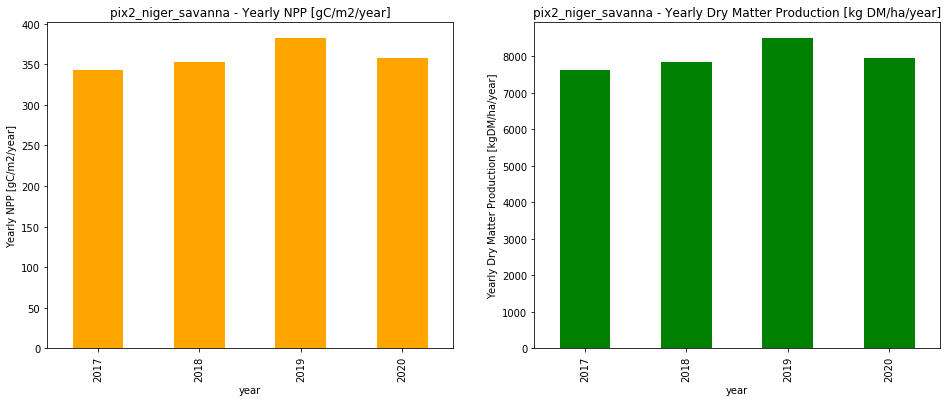

In [14]:
rescaling_factor = 10 * (1/0.45)

CUE = 0.5

figs, axs = plt.subplots(1, 2, figsize=(16, 6))

df_yearly_sum['NPPseasonal'] = df_yearly_sum['GPPseasonal'] * CUE 

df_yearly_sum['DMP_kg_per_ha'] = df_yearly_sum['NPPseasonal'] * rescaling_factor


df_yearly_sum['NPPseasonal'].plot.bar(ax=axs[0],color='orange')
axs[0].set_ylabel('Yearly NPP [gC/m2/year]')
axs[0].set_title(pixname+' - Yearly NPP [gC/m2/year]')


df_yearly_sum['DMP_kg_per_ha'].plot.bar(ax=axs[1],color='green')
axs[1].set_ylabel('Yearly Dry Matter Production [kgDM/ha/year]')
axs[1].set_title(pixname+' - Yearly Dry Matter Production [kg DM/ha/year]')


# The end

When you have reached this cell you have finalized the exercise. 